In [29]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import json
from matplotlib import pyplot as plt

dataframes = ["TheftEvent.parquet", "VisionEvent.parquet"]
attach_config_vars = ["generation_empty_w"]

folder = Path(".").resolve() / "data" / "experiments"
regex = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_(\d{5})"


def load_experiments_by_name(name) -> dict[str, pd.DataFrame]:

    dfs = {dfname: [] for dfname in dataframes}

    for ent in (folder / name).iterdir():

        if not ent.is_dir():
            continue

        res = re.match(regex, ent.name)
        
        if res is None:
            continue

        dstr, randstr = res.group(1), res.group(2)

        if not (ent / "config.json").is_file():
            continue

        with open(ent / "config.json", "r", encoding="utf-8") as f:
            config = json.load(f)
        
        skip_log = not all([(ent / dfname).is_file() for dfname in dataframes])
    
        if skip_log:
            continue

        for dfname in dataframes:
            df = pd.read_parquet(ent / dfname) 
            df["rand"]= randstr
            
            for av in attach_config_vars:
                df[av] = config[av]
            
            dfs[dfname].append(df)

        

    
    dfs = {dfname: pd.concat(inners, ignore_index=True) for dfname, inners in dfs.items()}

    return dfs

dfs = load_experiments_by_name("DENSE_VISION_mot_change_approach_vis_value")
df = dfs["TheftEvent.parquet"]
vision = dfs["VisionEvent.parquet"]

In [39]:
df[df["caught"]]  

,caught,thief_i,target_i,vision,cos_angle,t,rand,generation_empty_w
0,False,121,23,0.000000,-0.944046,4692,10051,1.0
1,False,124,33,0.100000,-0.613315,5627,10051,1.0
3,False,122,114,0.000000,-0.918126,6902,10051,1.0
4,False,129,95,0.000000,-0.888604,7208,10051,1.0
6,False,123,49,0.077500,-0.626538,8704,10051,1.0
...,...,...,...,...,...,...,...,...
13018,False,128,66,0.110000,-0.803669,116127,81458,100.0
13019,False,124,42,0.210000,-0.922404,116909,81458,100.0
13020,False,121,19,0.133215,0.290301,117028,81458,100.0
13021,False,123,40,0.000000,-0.665850,118864,81458,100.0


In [37]:



def custom(df: pd.DataFrame):
    df = df.drop(columns=["rand", "generation_empty_w"])
    n_grid = df.columns.size - 1
    n_time = df["t"].unique().size
    

vision.groupby("rand").apply(custom)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 't'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 't'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 't'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 't'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 't'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '1

""


Text(0, 0.5, 'N of thefts')

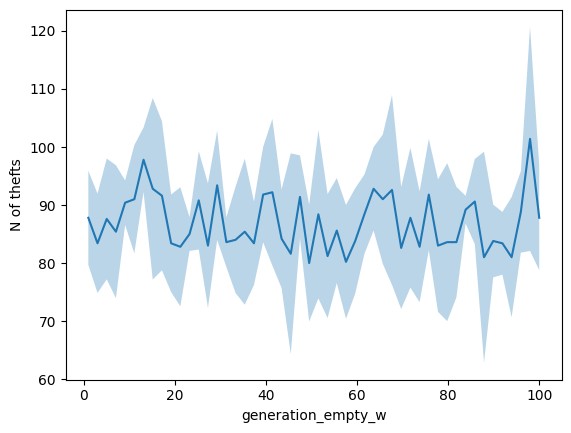

In [21]:
g = df.groupby(["rand", "generation_empty_w"])["caught"].value_counts()
g = g.reset_index()
g = g[~g["caught"]]

interest = "generation_empty_w"
def process(df: pd.DataFrame):
    return pd.DataFrame({"stole_mean": [df["count"].mean()], "stole_std": [df["count"].std()]})

g = g.groupby("generation_empty_w").apply(process)
g = g.reset_index().drop(columns="level_1")


fig, ax = plt.subplots()
ax.plot(g[interest], g["stole_mean"])
upper = g["stole_mean"] + g["stole_std"]
lower = g["stole_mean"] - g["stole_std"]

ax.fill_between(g[interest], upper, lower, alpha=0.3)
ax.set_xlabel(interest)
ax.set_ylabel("N of thefts")

<Axes: xlabel='generation_empty_w'>

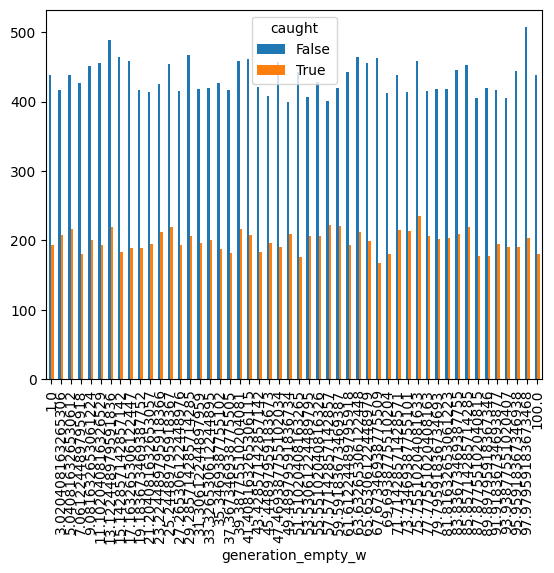

In [22]:
caught = df[df["caught"]]

df.groupby(interest)["caught"].value_counts().unstack().plot.bar()

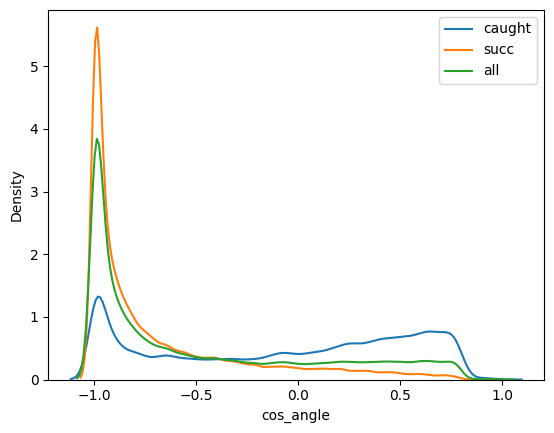

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

sns.kdeplot(df.loc[df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="caught")
sns.kdeplot(df.loc[~df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="succ")
sns.kdeplot(df.loc[:, "cos_angle"], bw_adjust=0.4, ax=ax, label="all")

ax.legend()
plt.show()

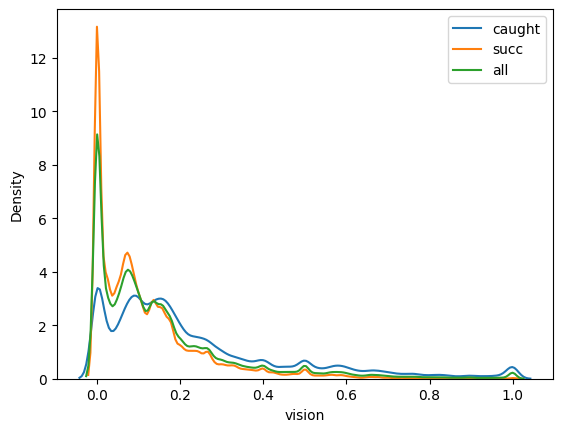

In [24]:
fig, ax = plt.subplots()

sns.kdeplot(df.loc[df["caught"], "vision"], bw_adjust=0.4, ax=ax, label="caught")
sns.kdeplot(df.loc[~df["caught"], "vision"], bw_adjust=0.4, ax=ax, label="succ")
sns.kdeplot(df.loc[:, "vision"], bw_adjust=0.4, ax=ax, label="all")

ax.legend()
plt.show()